### 패키지 로딩

In [27]:
import time; import random; import datetime
import warnings
warnings.filterwarnings("ignore")


import os
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt


%matplotlib inline

import contextlib
import wave 

import scipy

import librosa
import librosa.display
from glob import glob
from scipy.io import wavfile

from pydub import AudioSegment
from pydub.silence import split_on_silence
from scipy.signal import find_peaks 


import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

 

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout, MaxPooling2D, Activation,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add, AveragePooling2D, ReLU, MaxPool2D

)

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping

import cv2

### wave plot(파형 그래프)

Text(0.5, 1.0, 'Waveform')

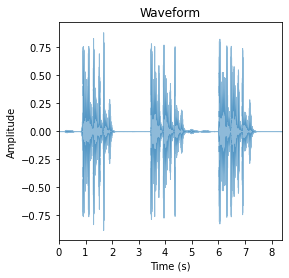

In [12]:
sig, sr = librosa.load('C:/Users/admin/corona_contest/public_dataset/00a4e142-2ae1-401e-8319-837e512b1281.wav', sr=16000)

plt.figure(figsize=(4,4))
librosa.display.waveplot(sig, sr, alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

### 푸리에 변환 그래프

Text(0.5, 1.0, 'Power spectrum')

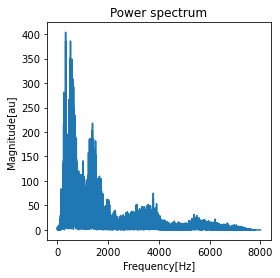

In [3]:
# Fourier -> Spectrum

fft = np.fft.fft(sig)

magnitude = np.abs(fft) 

f = np.linspace(0,sr,len(magnitude))

left_spectrum = magnitude[:int(len(magnitude) / 2)]
left_f = f[:int(len(magnitude) / 2)]

plt.figure(figsize=(4,4))
plt.plot(left_f, left_spectrum)
plt.xlabel("Frequency[Hz]")
plt.ylabel("Magnitude[au]")
plt.title("Power spectrum")

### STFT를 사용하는 스펙트로그램

Text(0.5, 1.0, 'Spectrogram (dB)')

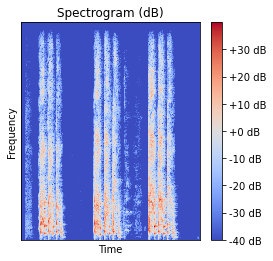

In [4]:
# STFT -> spectrogram

hop_length = 512
n_fft = 1024

hop_length_duration = float(hop_length) / sr
n_fft_duration = float(n_fft) / sr

stft = librosa.stft(sig, n_fft=n_fft, hop_length=hop_length)

magnitude = np.abs(stft)

log_spectrogram = librosa.amplitude_to_db(magnitude)

plt.figure(figsize=(4,4))
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")

### 메타데이터 정보 가져오기

In [2]:
metadata = pd.read_csv('C:/Users/admin/corona_contest/metadata_compiled.csv').iloc[:,:10]

In [3]:
# status 결측치 삭제
is_cough = metadata['cough_detected'] >= 0.5
metadata_res = metadata[is_cough].reset_index(drop=True)

In [4]:
files = 'C:/Users/admin/corona_contest/cut_wave/' + metadata_res['uuid'] + '.wav'

### Signal data cutting

In [8]:
files = metadata[metadata["cough_detected"]>=0.5]["uuid"].tolist()

In [9]:
def moving_average(a, n=100):
    ret = np.nancumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ret = ret[n - 1:] / n
    zero_arr = [0]*(n-1)
    return np.append(zero_arr, ret)

In [10]:
""" 이동 평균 모형을 이용하여 기침 소리 1주기 데이터만 plot 형태로 추출한 것
for file in files:
    sig, sr = librosa.load(path+"\\public_dataset\\"+file+".wav", sr=16000)
    
    #원본
    fig=plt.figure(figsize=(4,4))
    librosa.display.waveplot(sig, sr, alpha=0.5)
    plt.savefig('./original_plot/'+file+'.png')
    plt.close(fig)
    
    fp = find_peaks(list(sig), height=0.2)[0] #높이가 최소 0.2 이상인 값을 찾음

    fp_diff = np.diff(fp)>3000 #다음 기침은 최소 0.2초 이후에 한다 가정
    fp_diff = np.append(fp_diff, False) #차분 값의 마지막에 False 값 추가
    if sum(fp_diff)==0: fp_index = 0
    else: fp_index = list(fp[fp_diff]) #True인 값 추출 (차이가 커지기 전 인덱스 추출)
    
    #한주기
    if fp_index==0:
        fig=plt.figure(figsize=(4,4))
        librosa.display.waveplot(sig, sr, alpha=0.5)
        plt.savefig('./one_plot/'+file+'.png')
        plt.close(fig)
        
        yt,idx = librosa.effects.trim(sig, top_db = 10)
        
        fig=plt.figure(figsize=(4,4))
        librosa.display.waveplot(yt, sr, alpha=0.5)
        plt.savefig('./cut_plot/'+file+'.png')
        plt.close(fig)
        
        mv = moving_average(yt, 10)

        if sum(mv>0.2)!=0:
            mv_idx = list(mv>0.2).index(True)
            
            if len(yt[(mv_idx-100):])<1600: continue
            else:
                fig=plt.figure(figsize=(4,4))
                librosa.display.waveplot(yt[(mv_idx-100):], sr, alpha=0.5)
                plt.savefig('./mv_plot/'+file+'.png')
                plt.close(fig)
                
    else:
        fig=plt.figure(figsize=(4,4))
        librosa.display.waveplot(sig[:fp_index[0]], sr, alpha=0.5)
        plt.savefig('./one_plot/'+file+'.png')
        plt.close(fig)
        
        #cutting
        yt,idx = librosa.effects.trim(sig[:fp_index[0]], top_db = 10)
        
        fig=plt.figure(figsize=(4,4))
        librosa.display.waveplot(yt, sr, alpha=0.5)
        plt.savefig('./cut_plot/'+file+'.png')
        plt.close(fig)
        
        mv = moving_average(yt, 10)
        
        if sum(mv>0.2)!=0:

            mv_idx = list(mv>0.2).index(True)

            if len(yt[(mv_idx-100):])<1600: continue
            else:
                fig=plt.figure(figsize=(4,4))
                librosa.display.waveplot(yt[(mv_idx-100):], sr, alpha=0.5)
                plt.savefig('./mv_plot/'+file+'.png')
                plt.close(fig)
                
"""

' 이동 평균 모형을 이용하여 기침 소리 1주기 데이터만 plot 형태로 추출한 것\nfor file in files:\n    sig, sr = librosa.load(path+"\\public_dataset\\"+file+".wav", sr=16000)\n    \n    #원본\n    fig=plt.figure(figsize=(4,4))\n    librosa.display.waveplot(sig, sr, alpha=0.5)\n    plt.savefig(\'./original_plot/\'+file+\'.png\')\n    plt.close(fig)\n    \n    fp = find_peaks(list(sig), height=0.2)[0] #높이가 최소 0.2 이상인 값을 찾음\n\n    fp_diff = np.diff(fp)>3000 #다음 기침은 최소 0.2초 이후에 한다 가정\n    fp_diff = np.append(fp_diff, False) #차분 값의 마지막에 False 값 추가\n    if sum(fp_diff)==0: fp_index = 0\n    else: fp_index = list(fp[fp_diff]) #True인 값 추출 (차이가 커지기 전 인덱스 추출)\n    \n    #한주기\n    if fp_index==0:\n        fig=plt.figure(figsize=(4,4))\n        librosa.display.waveplot(sig, sr, alpha=0.5)\n        plt.savefig(\'./one_plot/\'+file+\'.png\')\n        plt.close(fig)\n        \n        yt,idx = librosa.effects.trim(sig, top_db = 10)\n        \n        fig=plt.figure(figsize=(4,4))\n        librosa.display.waveplot(yt, sr, alpha=0.5)\

### 이동평균으로 자른 데이터 .wav로 저장

In [ ]:
for file in files:
    sig, sr = librosa.load(path+"\\public_dataset\\"+file+".wav", sr=16000)
    
    fp = find_peaks(list(sig), height=0.2)[0] #높이가 최소 0.2 이상인 값을 찾음

    fp_diff = np.diff(fp)>3000 #다음 기침은 최소 0.2초 이후에 한다 가정
    fp_diff = np.append(fp_diff, False) #차분 값의 마지막에 False 값 추가
    if sum(fp_diff)==0: fp_index = 0
    else: fp_index = list(fp[fp_diff]) #True인 값 추출 (차이가 커지기 전 인덱스 추출)
    
    #한주기
    if fp_index==0:
        yt,idx = librosa.effects.trim(sig, top_db = 10)
        
        mv = moving_average(yt, 10)

        if sum(mv>0.2)!=0:
            mv_idx = list(mv>0.2).index(True)
            
            if len(yt[(mv_idx-100):])<1600: continue
            else:
                librosa.output.write_wav('./cut_wave/'+file+'.wav',
                                         yt[(mv_idx-100):], sr)
                
    else:
        yt,idx = librosa.effects.trim(sig[:fp_index[0]], top_db = 10)
        
        mv = moving_average(yt, 10)
        
        if sum(mv>0.2)!=0:
            mv_idx = list(mv>0.2).index(True)

            if len(yt[(mv_idx-100):])<1600: continue
            else:
                librosa.output.write_wav('./cut_wave/'+file+'.wav',
                                         yt[(mv_idx-100):], sr)

### Spectrogram Plot 1

In [98]:
cut_wave = os.listdir('C:/Users/admin/corona_contest/cut_wave')

In [99]:
waves = []
for i in cut_wave:
    waves.append(i[:-4])

In [100]:
metadata_resl = metadata[metadata['uuid'].isin(waves)].reset_index(drop=True)

In [101]:
metadata_resl

,uuid,datetime,cough_detected,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,status
0,00039425-7f3a-42aa-ac13-834aaa2b6b92,2020-04-13T21:30:59.801831+00:00,0.9609,31.3,34.8,15.0,male,False,False,healthy
1,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,2020-04-13T22:23:06.997578+00:00,0.9968,NaN,NaN,21.0,male,False,False,healthy
2,00291cce-36a0-4a29-9e2d-c1d96ca17242,2020-04-13T15:10:58.405156+00:00,0.9883,39.4,67.2,15.0,male,False,False,healthy
3,002d28bc-7806-4dfb-9c9b-afa8cb623cac,2020-04-16T22:10:24.107938+00:00,0.9959,NaN,NaN,46.0,female,False,False,healthy
4,002db0bd-e57f-4c30-ade0-16640d424eb7,2020-04-13T19:51:11.397697+00:00,0.9536,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
9566,ffe5e2a4-ef67-464d-b1cd-b0e321f6a2dd,2020-04-22T05:40:51.730942+00:00,0.5591,13.0,77.6,26.0,male,False,False,healthy
9567,ffeea120-92a4-40f9-b692-c3865c7a983f,2020-05-02T10:18:27.348859+00:00,0.9784,14.3,121.1,22.0,female,False,False,healthy
9568,fff13fa2-a725-49ef-812a-39c6cedda33d,2020-04-13T17:51:36.956822+00:00,0.7154,31.9,34.7,21.0,male,True,False,healthy
9569,fff3ff61-2387-4139-938b-539db01e6be5,2020-06-28T21:28:21.530881+00:00,0.5257,51.6,-0.2,NaN,female,False,False,symptomatic


In [104]:
# 이미지 array 얻는 함수
def graph_spectrogram(wav_file, nfft=1024, noverlap=1023):
    data ,rate = librosa.load(wav_file,sr=16000)
    #print("")
    fig,ax = plt.subplots(1)
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    ax.axis('off')
    pxx, freqs, bins, im = ax.specgram(x=data, Fs=rate, noverlap=noverlap, NFFT=nfft)
    ax.axis('off')
    plt.rcParams['figure.figsize'] = [0.75,0.5]
    #fig.savefig('sp_xyz.png', dpi=300, frameon='false')
    fig.canvas.draw()
    size_inches  = fig.get_size_inches()
    dpi          = fig.get_dpi()
    width, height = fig.get_size_inches() * fig.get_dpi()

    #print(size_inches, dpi, width, height)
    mplimage = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    #print("MPLImage Shape: ", np.shape(mplimage))
    imarray = np.reshape(mplimage, (int(height), int(width), 3))
    re_imarray = cv2.resize(imarray, (54, 36), interpolation=cv2.INTER_CUBIC)
    plt.close(fig)
    return re_imarray

In [105]:
# rgb 이미지 불러오기
img = []
for idx in range(len(cut_wave)):
    data ,rate = librosa.load('../cut_wave/' + cut_wave[idx])
    img.append(graph_spectrogram('../cut_wave/' + cut_wave[idx], nfft=len(data), noverlap=len(data)-1))

In [106]:
img_arr = np.array(img)

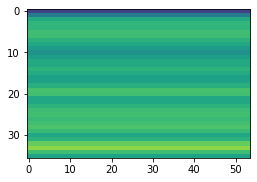

In [107]:
# COVID-19 데이터
plt.figure(figsize=(4,4))
plt.imshow(img_arr[38])
plt.show()

In [178]:
import cv2

In [183]:
cv2.imshow('a', img_arr[38])
cv2.waitKey(0)
cv2.destroyAllWindows()

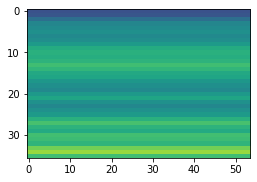

In [182]:
# symptomatic 데이터
plt.figure(figsize=(4,4))
plt.imshow(img_arr[0])
plt.show()

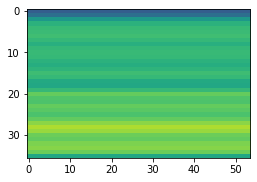

In [109]:
# healthy 데이터
plt.figure(figsize=(4,4))
plt.imshow(img_arr[1])
plt.show()

### Spectrogram plot 2

In [110]:
def graph_spectrogram_2(wav_file, hop_length = 512, n_fft = 1024, sr=16000):

    sig, sr = librosa.load(wav_file, sr=sr)
    
    hop_length_duration = float(hop_length) / sr
    n_fft_duration = float(n_fft) / sr
    stft = librosa.stft(sig, n_fft=n_fft, hop_length=hop_length)
    magnitude = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(magnitude)
    
    fig,ax = plt.subplots(1)
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    ax.axis('off')
    librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
    ax.axis('off')
    plt.rcParams['figure.figsize'] = [0.75,0.5]
    fig.canvas.draw()
    size_inches  = fig.get_size_inches()
    dpi          = fig.get_dpi()
    width, height = fig.get_size_inches() * fig.get_dpi()
    
    mplimage = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    imarray = np.reshape(mplimage, (int(height), int(width), 3))
    re_imarray = cv2.resize(imarray, (54, 36), interpolation=cv2.INTER_AREA)
    plt.close(fig)
    return re_imarray

In [111]:
# rgb 이미지 불러오기
imgs = []
for idx in range(len(cut_wave)):
    imgs.append(graph_spectrogram_2('../cut_wave/' + cut_wave[idx]))

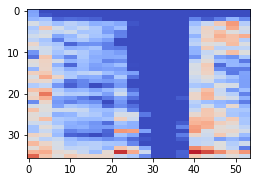

In [112]:
# COVID-19 데이터
plt.figure(figsize=(4,4))
plt.imshow(imgs[38])
plt.show()

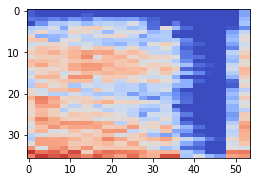

In [113]:
# symptomatic 데이터
plt.figure(figsize=(4,4))
plt.imshow(imgs[0])
plt.show()

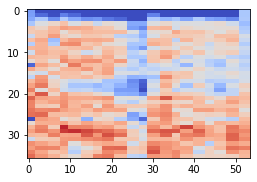

In [114]:
# healthy 데이터
plt.figure(figsize=(4,4))
plt.imshow(imgs[1])
plt.show()

In [115]:
def graph_spectrogram_3(wav_file, sr=16000):
    
    sig, sr = librosa.load(wav_file, sr=sr)
    n_fft = 512
    win_length = 400
    hop_length = 160
    n_mels = 80

    D = np.abs(librosa.stft(sig, n_fft=n_fft, win_length = win_length, hop_length=hop_length))
    mel_spec = librosa.feature.melspectrogram(S=D, sr=sr, n_mels=n_mels, hop_length=hop_length, win_length=win_length)
    
    fig,ax = plt.subplots(1)
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    ax.axis('off')
    librosa.display.specshow(librosa.amplitude_to_db(mel_spec, ref=0.00002), sr=sr, hop_length = hop_length, cmap = plt.cm.jet)
    ax.axis('off')
    plt.rcParams['figure.figsize'] = [0.75,0.5]
    fig.canvas.draw()
    size_inches  = fig.get_size_inches()
    dpi          = fig.get_dpi()
    width, height = fig.get_size_inches() * fig.get_dpi()
    
    mplimage = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    imarray = np.reshape(mplimage, (int(height), int(width), 3))
    re_imarray = cv2.resize(imarray, (54, 36), interpolation=cv2.INTER_AREA)
    plt.close(fig)
    return re_imarray



In [116]:
# rgb 이미지 불러오기
imgss = []
for idx in range(len(cut_wave)):
    imgss.append(graph_spectrogram_3('../cut_wave/' + cut_wave[idx]))

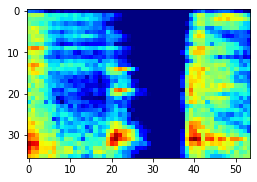

In [117]:
# COVID-19 데이터
plt.figure(figsize=(4,4))
plt.imshow(imgss[38])
plt.show()

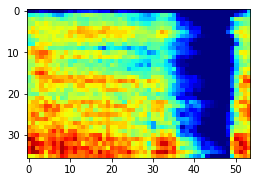

In [118]:
# symptomatic 데이터
plt.figure(figsize=(4,4))
plt.imshow(imgss[0])
plt.show()

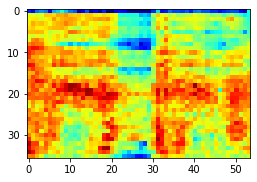

In [119]:
# healthy 데이터
plt.figure(figsize=(4,4))
plt.imshow(imgss[1])
plt.show()

In [120]:
# 1
img_arr = np.array(img)
# 2
img_arr2 = np.array(imgs)
# 3
img_arr3 = np.array(imgss)

In [121]:
img_arr.shape

(9571, 36, 54, 3)

In [122]:
img_arr2.shape

(9571, 36, 54, 3)

In [123]:
img_arr3.shape

(9571, 36, 54, 3)

### train-test set

In [19]:
nan_remove_index = metadata_resl[metadata_resl['status'].notnull()].index.tolist()

In [184]:
# Train data 80% : test data 20%로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(img_arr2[nan_remove_index], np.array(metadata_resl['status'][nan_remove_index]), test_size=0.2, shuffle=False)

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [185]:
y_train = np.array(y_train)
y_test = np.array(y_test)

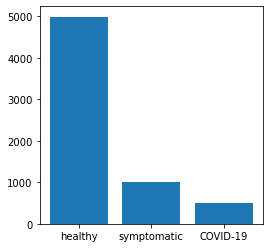

In [186]:
plt.figure(figsize=(4,4))
plt.bar(metadata_resl['status'][nan_remove_index].value_counts().index, metadata_resl['status'][nan_remove_index].value_counts())
plt.show()

In [187]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [188]:
inputs = Input(shape = (36,54,3))

x = Conv2D(filters=32, kernel_size=(3,3), padding='SAME', activation='relu')(inputs)
x = BatchNormalization()(x)
x_res = x
x = Conv2D(filters=32, kernel_size=(3,3), padding='SAME', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=32, kernel_size=(3,3), padding='SAME', activation='relu')(x)
x = BatchNormalization()(x)
x = Add()([x, x_res])
x = AveragePooling2D()(x)
x = Dropout(0.5)(x)

x = Conv2D(filters=64, kernel_size=(3,3), padding='SAME', activation='relu')(x)
x = BatchNormalization()(x)
x_res = x
x = Conv2D(filters=64, kernel_size=(3,3), padding='SAME', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=64, kernel_size=(3,3), padding='SAME', activation='relu')(x)
x = BatchNormalization()(x)
x = Add()([x, x_res])
x = AveragePooling2D()(x)
x = Dropout(0.5)(x)

x = Conv2D(filters=128, kernel_size=(3,3), padding='SAME', activation='relu')(x)
x = BatchNormalization()(x)
x_res = x
x = Conv2D(filters=128, kernel_size=(3,3), padding='SAME', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=128, kernel_size=(3,3), padding='SAME', activation='relu')(x)
x = BatchNormalization()(x)
x = Add()([x, x_res])
x = AveragePooling2D()(x)
x = Dropout(0.5)(x)

x = Conv2D(filters=64, kernel_size=(1,1), padding='SAME', activation='relu')(x)
x = Conv2D(filters=64, kernel_size=(3,3), padding='SAME', activation='relu')(x)
x = Conv2D(filters=256, kernel_size=(1,1), padding='SAME', activation='relu')(x)
x = BatchNormalization()(x)
x_res = x
x = Conv2D(filters=64, kernel_size=(1,1), padding='SAME', activation='relu')(x)
x = Conv2D(filters=64, kernel_size=(3,3), padding='SAME', activation='relu')(x)
x = Conv2D(filters=256, kernel_size=(1,1), padding='SAME', activation='relu')(x)
x = BatchNormalization()(x)
x = Add()([x, x_res])
x = AveragePooling2D()(x)
x = Dropout(0.5)(x)

x = Conv2D(filters=128, kernel_size=(1,1), padding='SAME', activation='relu')(x)
x = Conv2D(filters=128, kernel_size=(3,3), padding='SAME', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=(1,1), padding='SAME', activation='relu')(x)
x = BatchNormalization()(x)
x_res = x
x = Conv2D(filters=128, kernel_size=(1,1), padding='SAME', activation='relu')(x)
x = Conv2D(filters=128, kernel_size=(3,3), padding='SAME', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=(1,1), padding='SAME', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=128, kernel_size=(1,1), padding='SAME', activation='relu')(x)
x = Conv2D(filters=128, kernel_size=(3,3), padding='SAME', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=(1,1), padding='SAME', activation='relu')(x)
x = BatchNormalization()(x)
x = Add()([x, x_res])
x = AveragePooling2D()(x)
x = Dropout(0.5)(x)

x = Flatten()(x)

x = Dense(units=128)(x)
x = BatchNormalization()(x)
x_res = x
x = Dropout(0.5)(x)

x = Dense(units=128)(x)
x = BatchNormalization()(x)
x = Add()([x, x_res])
x = Dropout(0.5)(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 36, 54, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_199 (Conv2D)             (None, 36, 54, 32)   896         input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_132 (BatchN (None, 36, 54, 32)   128         conv2d_199[0][0]                 
__________________________________________________________________________________________________
conv2d_200 (Conv2D)             (None, 36, 54, 32)   9248        batch_normalization_132[0][0]    
____________________________________________________________________________________________

In [189]:
opt = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy',
                                                                      tensorflow.keras.metrics.FalseNegatives(name='false_negatives')])

In [190]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                              steps_per_epoch=len(X_train) / 32, 
                              epochs=16, 
                              validation_data=(X_test, y_test), 
                              class_weight={0:0.76, 1:0.09, 2:0.15})

Epoch 1/16
163/162 [==============================] - 74s 452ms/step - loss: 0.2619 - acc: 0.4028 - false_negatives: 3483.0000 - val_loss: 0.9612 - val_acc: 0.7727 - val_false_negatives: 1302.0000
Epoch 2/16
163/162 [==============================] - 44s 270ms/step - loss: 0.2124 - acc: 0.4616 - false_negatives: 3442.0000 - val_loss: 0.8951 - val_acc: 0.7727 - val_false_negatives: 437.0000
Epoch 3/16
163/162 [==============================] - 44s 270ms/step - loss: 0.1900 - acc: 0.4973 - false_negatives: 3486.0000 - val_loss: 0.8960 - val_acc: 0.7696 - val_false_negatives: 622.0000
Epoch 4/16
163/162 [==============================] - 45s 279ms/step - loss: 0.1777 - acc: 0.5090 - false_negatives: 3634.0000 - val_loss: 0.9924 - val_acc: 0.7665 - val_false_negatives: 1301.0000
Epoch 5/16
163/162 [==============================] - 46s 280ms/step - loss: 0.1685 - acc: 0.4987 - false_negatives: 3983.0000 - val_loss: 0.9614 - val_acc: 0.7657 - val_false_negatives: 1228.0000
Epoch 6/16
163/16

Epoch 14/16
163/162 [==============================] - 58s 353ms/step - loss: 0.1548 - acc: 0.6174 - false_negatives: 4842.0000 - val_loss: 0.9476 - val_acc: 0.7727 - val_false_negatives: 1301.0000
Epoch 15/16
163/162 [==============================] - 57s 351ms/step - loss: 0.1547 - acc: 0.6925 - false_negatives: 4575.0000 - val_loss: 0.9251 - val_acc: 0.7727 - val_false_negatives: 1302.0000
Epoch 16/16
163/162 [==============================] - 59s 363ms/step - loss: 0.1558 - acc: 0.6626 - false_negatives: 4794.0000 - val_loss: 1.1099 - val_acc: 0.7028 - val_false_negatives: 926.0000


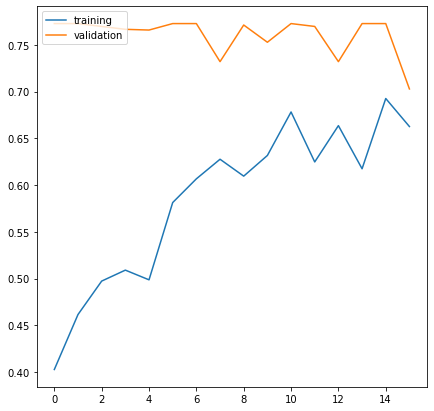

In [191]:
plt.figure(figsize=(7,7))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

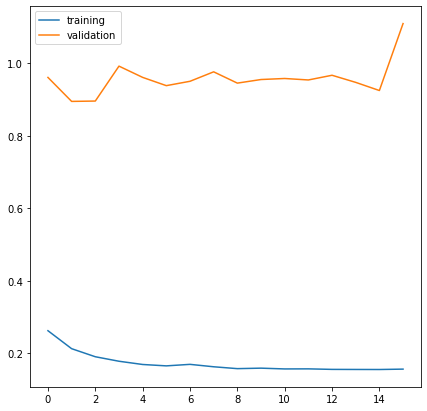

In [192]:
plt.figure(figsize=(7,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

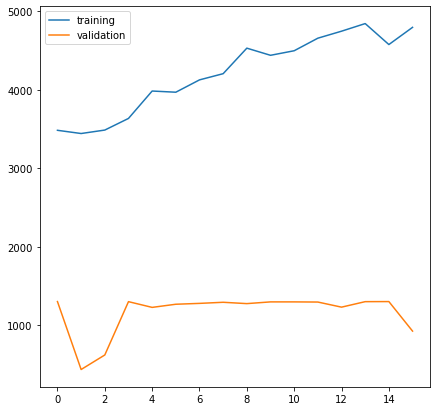

In [193]:
plt.figure(figsize=(7,7))
plt.plot(history.history['false_negatives'])
plt.plot(history.history['val_false_negatives'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [194]:
CLASSES = np.array(['COVID-19','healthy','symptomatic'])

pred = model.predict(X_test)
pred_single = CLASSES[np.argmax(pred, axis=-1)]
actual_single = CLASSES[np.argmax(y_test, axis=-1)]

In [195]:
resultss = pd.DataFrame(pred_single,columns=['aa'])

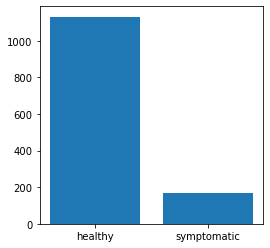

In [196]:
plt.figure(figsize=(4,4))
plt.bar(resultss['aa'].value_counts().index, resultss['aa'].value_counts())
plt.show()

In [197]:
resultss['aa'].value_counts()

healthy        1132
symptomatic     170
Name: aa, dtype: int64

In [198]:
actual_single

array(['healthy', 'symptomatic', 'healthy', ..., 'healthy', 'healthy',
       'symptomatic'], dtype='<U11')

In [199]:
from sklearn.metrics import confusion_matrix
confusion_matrix(actual_single,pred_single,labels=['COVID-19','healthy','symptomatic'])

array([[  0,  86,  13],
       [  0, 882, 124],
       [  0, 164,  33]], dtype=int64)

In [200]:
train_pred = model.predict(X_train)
train_pred_single = CLASSES[np.argmax(train_pred, axis=-1)]
train_actual_single = CLASSES[np.argmax(y_train, axis=-1)]

In [201]:
train_result = pd.DataFrame(pred_single,columns=['aa'])

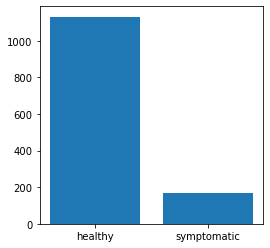

In [202]:
plt.figure(figsize=(4,4))
plt.bar(train_result['aa'].value_counts().index, train_result['aa'].value_counts())
plt.show()

In [203]:
train_result['aa'].value_counts()

healthy        1132
symptomatic     170
Name: aa, dtype: int64

In [204]:
from sklearn.metrics import confusion_matrix
confusion_matrix(train_actual_single,train_pred_single,labels=['COVID-19','healthy','symptomatic'])

array([[   0,  337,   58],
       [   3, 3509,  475],
       [   1,  708,  113]], dtype=int64)

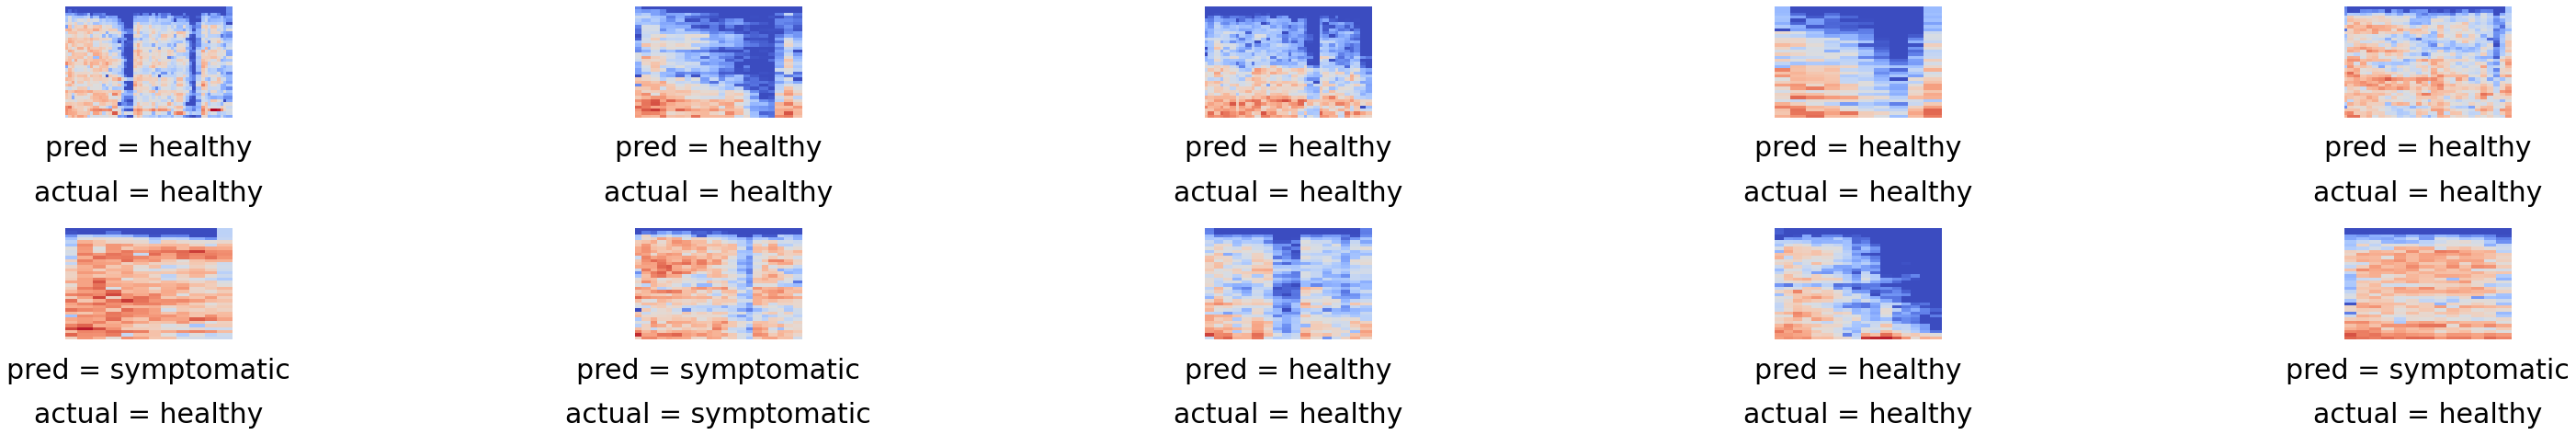

In [205]:
show_n = 10
indices = np.random.choice(range(len(X_test)),show_n)

fig = plt.figure(figsize=(50, 20))
fig.subplots_adjust(hspace = 1, wspace = 1)

for i, idx in enumerate(indices):
    imgsaa = X_test[idx]
    ax = fig.add_subplot(5, show_n/2, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(pred_single[idx]), fontsize=30, ha ='center', transform = ax.transAxes)
    ax.text(0.5, -0.75, 'actual = ' + str(actual_single[idx]), fontsize=30, ha ='center', transform = ax.transAxes)
    ax.imshow(imgsaa)

In [206]:
model.save('../model/model_exam.h5')